## Using description column to group products

<b>Problem Definition</b>:
Build a model to order supplies of a given product based on the time of year. <br>
<br>
<b>Planned Goals</b>: Group products based on the unsupervised method using description column.<br>
<br>
<b>Achieved Goals</b>: Probably the hypothesis of using only description to group products is wrong.<br>
<br>
<b>To-Do(s)</b>: Using hybrid approach to enhance the segregation results. <br>
<br>
<b>Contributors</b>: Kayhan B (Nov 2021)<br>
<br>
<b>Reviewers</b>: -<br>
<br>

<b>General Information</b>:<br>
- Please read the README for python virtual environment. <br>
- Use data-exploration.ipynb before this notebook.
<br>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
from sentence_transformers import SentenceTransformer, util
import time
import torch
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import seaborn as sns

import lib.helper_pandas as hp



In [2]:
%%time
# @formatter:on

df = pd.read_parquet(path = './data/retail-transaction-clean-v1.parquet', engine = 'pyarrow')
n_rows = len(df.index)
n_cols = len(df.columns)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")

display(df.dtypes)
hp.unique_col_percent(df = df)
hp.null_val_summary(df = df)
df.head()



Dataframe length is: 528901
Number of columns is: 12


InvoiceNo                string
StockCode                string
Description              string
Quantity                  int64
InvoiceDate      datetime64[ns]
UnitPrice               float64
CustomerID                int64
Country                  string
InvoiceNoNum              int64
StockCodeNum              int64
StockCodeChar            string
TotalPrice              float64
dtype: object

InvoiceNo unique count and percentage: 20513, 3.88
StockCode unique count and percentage: 3805, 0.72
Description unique count and percentage: 4038, 0.76
Quantity unique count and percentage: 390, 0.07
InvoiceDate unique count and percentage: 18877, 3.57
UnitPrice unique count and percentage: 901, 0.17
CustomerID unique count and percentage: 4336, 0.82
Country unique count and percentage: 38, 0.01
InvoiceNoNum unique count and percentage: 20513, 3.88
StockCodeNum unique count and percentage: 3289, 0.62
StockCodeChar unique count and percentage: 28, 0.01
TotalPrice unique count and percentage: 4865, 0.92


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 1.18 s


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34


white hanging heart t-light holder    2328
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: Description, dtype: Int64

vintage union jack bunting            487
set of 3 wooden heart decorations     487
doormat spotty home sweet home        486
small heart measuring spoons          485
set/3 red gingham rose storage box    482
ladies & gentlemen metal sign         482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: Description, dtype: Int64

pink beads+hand phone charm           1
fba                                   1
ruby glass cluster necklace           1
small tahiti beach bag                1
blossom images scrap book set         1
orange felt vase + flowers            1
green/blue ceramic candle holder      1
ant silver turquoise boudicca ring    1
blue/yellow ceramic candle holder     1
paper craft , little birdie           1
Name: Description, dtype: Int64

Wall time: 1.53 s


<BarContainer object of 20 artists>

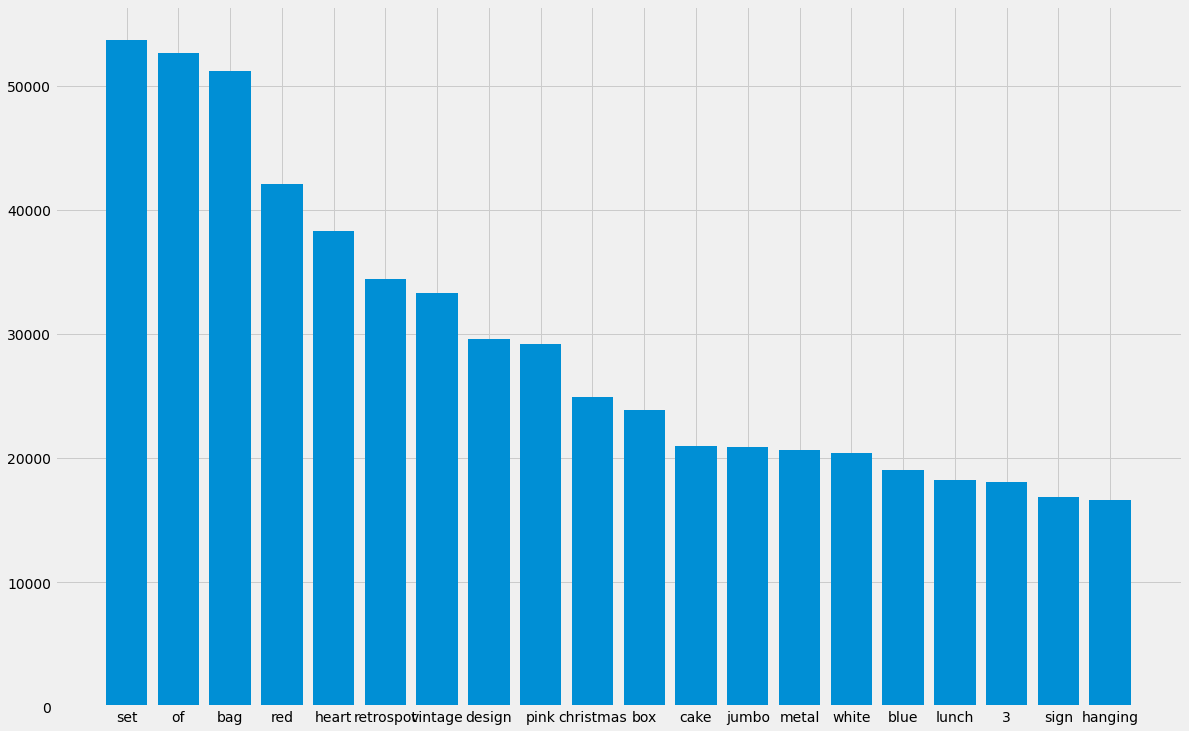

In [3]:
%%time
# @formatter:on

display(df['Description'].value_counts(dropna = False)[:10])
display(df['Description'].value_counts(dropna = False)[200:210])
display(df['Description'].value_counts(dropna = False)[-10:])

w = dict(Counter([i for j in df['Description'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (18, 12))
plt.bar(w.keys(), w.values())



In [4]:
%%time
# @formatter:on

# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy

def case_folder(text):
    return text.casefold()


df['DescriptionEdited'] = df['Description'].apply(lambda x: case_folder(x))
display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['Description'])])
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2328
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: DescriptionEdited, dtype: int64

vintage union jack bunting            487
set of 3 wooden heart decorations     487
doormat spotty home sweet home        486
small heart measuring spoons          485
ladies & gentlemen metal sign         482
set/3 red gingham rose storage box    482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: DescriptionEdited, dtype: int64

mint diner clock                      1
set of 3 pink flying ducks            1
pink feather christmas decoration     1
filigree diamante chain               1
pink cherry blossom cup & saucer      1
had been put aside.                   1
ocean scent candle jewelled drawer    1
happy birthday card teddy/cake        1
wrap  pink flock                      1
paper craft , little birdie           1
Name: DescriptionEdited, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited


unique values count: 4038
Wall time: 426 ms


In [5]:
%%time
# @formatter:on

# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.

def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_number(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2328
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set 7 babushka nesting boxes,set babushka nesting boxes
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of 6 assorted colour teaspoons,box of assorted colour teaspoons
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/2 red retrospot tea towels,set/ red retrospot tea towels
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of4 woodland,round snack boxes set of woodland
42,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,france,536370,22900,,70.80,set 2 tea towels i love london,set tea towels i love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528876,581585,22398,magnets pack of 4 swallows,12,2011-12-09 12:31:00,0.39,15804,united kingdom,581585,22398,,4.68,magnets pack of 4 swallows,magnets pack of swallows
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set 6 school milk bottles in crate,set school milk bottles in crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of 3 hanging owls ollie beak,set of hanging owls ollie beak
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack of 20 spaceboy napkins,pack of spaceboy napkins


unique values count: 3978
Wall time: 1.46 s


In [6]:
%%time
# @formatter:on

# removing possessive and verb s

def remove_possessive(text):
    return text.replace("'s", '')


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_possessive(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2328
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
11,536367,22745,poppy's playhouse bedroom,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22745,,12.60,poppy's playhouse bedroom,poppy playhouse bedroom
12,536367,22748,poppy's playhouse kitchen,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22748,,12.60,poppy's playhouse kitchen,poppy playhouse kitchen
45,536371,22086,paper chain kit 50's christmas,80,2010-12-01 09:00:00,2.55,13748,united kingdom,536371,22086,,204.00,paper chain kit 's christmas,paper chain kit christmas
116,536381,22086,paper chain kit 50's christmas,4,2010-12-01 09:41:00,2.95,15311,united kingdom,536381,22086,,11.80,paper chain kit 's christmas,paper chain kit christmas
373,536402,22086,paper chain kit 50's christmas,40,2010-12-01 11:22:00,2.55,15513,united kingdom,536402,22086,,102.00,paper chain kit 's christmas,paper chain kit christmas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528686,581538,23319,box of 6 mini 50's crackers,1,2011-12-09 11:34:00,2.49,14446,united kingdom,581538,23319,,2.49,box of mini 's crackers,box of mini crackers
528804,581579,22086,paper chain kit 50's christmas,12,2011-12-09 12:19:00,2.95,17581,united kingdom,581579,22086,,35.40,paper chain kit 's christmas,paper chain kit christmas
528807,581579,23319,box of 6 mini 50's crackers,12,2011-12-09 12:19:00,2.49,17581,united kingdom,581579,23319,,29.88,box of mini 's crackers,box of mini crackers
528825,581579,23344,jumbo bag 50's christmas,20,2011-12-09 12:19:00,1.79,17581,united kingdom,581579,23344,,35.80,jumbo bag 's christmas,jumbo bag christmas


unique values count: 3978
Wall time: 472 ms


In [7]:
%%time
# @formatter:on

# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", "", text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_special_char(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2328
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
lunch bag red retrospot              1594
assorted colour bird ornament        1489
french blue metal door sign          1488
set of  cake tins pantry design      1401
pack of  retrospot cake cases        1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set of  wooden heart decorations    487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies  gentlemen metal sign        482
feltcraft cushion owl               481
set  colour pencils spaceboy        481
Name: DescriptionEditedTemp, dtype: int64

jam jar with blue lid                 1
baking mould toffee cup  chocolate    1
baking mould cupcake chocolate        1
gold cosmetics bag with butterfly     1
pinkwhite glass demi choker           1
fba                                   1
marie antoienett trinket box gold     1
greenblue ceramic candle holder       1
black christmas flock droplet         1
paper craft  little birdie            1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart.,red woolly hottie white heart
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,united kingdom,536365,21730,,25.50,glass star frosted t-light holder,glass star frosted tlight holder
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/ red retrospot tea towels,set red retrospot tea towels
48,536373,85123a,white hanging heart t-light holder,6,2010-12-01 09:02:00,2.55,17850,united kingdom,536373,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528859,581584,85038,6 chocolate love heart t-lights,48,2011-12-09 12:25:00,1.85,13777,united kingdom,581584,85038,,88.80,chocolate love heart t-lights,chocolate love heart tlights
528861,581585,84945,multi colour silver t-light holder,24,2011-12-09 12:31:00,0.85,15804,united kingdom,581585,84945,,20.40,multi colour silver t-light holder,multi colour silver tlight holder
528864,581585,22178,victorian glass hanging t-light,12,2011-12-09 12:31:00,1.95,15804,united kingdom,581585,22178,,23.40,victorian glass hanging t-light,victorian glass hanging tlight
528875,581585,84946,antique silver t-light glass,12,2011-12-09 12:31:00,1.25,15804,united kingdom,581585,84946,,15.00,antique silver t-light glass,antique silver tlight glass


unique values count: 3968
Wall time: 1.08 s


In [8]:
%%time
# @formatter:on

# removing words with less than 3 character

def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_short_word(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2328
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set   cake tins pantry design        1401
pack   retrospot cake cases          1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

pantry magnetic  shopping list      489
lunch box with cutlery retrospot    489
jumbo bag vintage christmas         489
vintage union jack bunting          487
set   wooden heart decorations      487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies  gentlemen metal sign        482
feltcraft cushion owl               481
Name: DescriptionEditedTemp, dtype: int64

christmas table candle silver spike    1
white frangipani hair clip             1
pearl  shell neckl ivory               1
baroque butterfly earrings montana     1
zinc star tlight holder                1
incorrectly credited  see              1
capiz chandelier                       1
  cutlery set pantry design            1
lily brooch whitesilver colour         1
paper craft  little birdie             1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box of vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box of vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of woodland,round snack boxes set woodland
36,536370,22659,lunch box i love london,24,2010-12-01 08:45:00,1.95,12583,france,536370,22659,,46.80,lunch box i love london,lunch box love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set school milk bottles in crate,set school milk bottles crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters in tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters in tin circus parade,plasters tin circus parade


unique values count: 3935
Wall time: 1.25 s


In [9]:
%%time
# @formatter:on

# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_extra_whitespace_tabs(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2328
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot    489
jumbo bag vintage christmas         489
pantry magnetic shopping list       489
vintage union jack bunting          487
set wooden heart decorations        487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

baking mould cupcake chocolate        1
gold cosmetics bag with butterfly     1
blue drop earrings bead cluster       1
purple anemone artificial flower      1
ocean scent candle jewelled drawer    1
pinkwhite glass demi choker           1
purpleturq flowers handbag            1
black christmas flock droplet         1
wrap pink flock                       1
paper craft little birdie             1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set babushka nesting boxes,set babushka nesting boxes
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set woodland,round snack boxes set woodland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters tin circus parade,plasters tin circus parade
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkins


unique values count: 3921
Wall time: 1.98 s


In [10]:
%%time
# @formatter:on

display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])



white hanging heart tlight holder    2328
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEdited, dtype: int64

lunch box with cutlery retrospot    489
jumbo bag vintage christmas         489
pantry magnetic shopping list       489
vintage union jack bunting          487
set wooden heart decorations        487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEdited, dtype: int64

baking mould cupcake chocolate        1
gold cosmetics bag with butterfly     1
blue drop earrings bead cluster       1
purple anemone artificial flower      1
ocean scent candle jewelled drawer    1
pinkwhite glass demi choker           1
purpleturq flowers handbag            1
black christmas flock droplet         1
wrap pink flock                       1
paper craft little birdie             1
Name: DescriptionEdited, dtype: int64

Wall time: 209 ms


In [11]:
%%time
# @formatter:on

# python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable = ['parser', 'ner'])
print(nlp.pipe_names)



['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']
Wall time: 1.56 s


In [12]:
%%time
# @formatter:on

unique_desc = list(df['DescriptionEdited'].unique())

# New stop words list
customized_stop_words = [
    'alice blue', 'antique white',
    'aqua', 'aquamarine',
    'azure', 'beige',
    'bisque', 'black',
    'blanched almond', 'blue',
    'blue violet', 'brown',
    'burly wood', 'cadet blue',
    'chartreuse', 'chocolate',
    'coral', 'cornflower blue',
    'cornsilk', 'crimson',
    'cyan', 'dark blue',
    'dark cyan', 'dark golden rod',
    'dark gray', 'dark grey',
    'dark green', 'dark khaki',
    'dark magenta', 'dark olive green',
    'dark orange', 'dark orchid',
    'dark red', 'dark salmon',
    'dark sea green', 'dark slate blue',
    'dark slate gray', 'dark slate grey',
    'dark turquoise', 'dark violet',
    'deep pink', 'deep sky blue',
    'dim gray', 'dim grey',
    'dodger blue', 'fire brick',
    'floral white', 'forest green',
    'fuchsia', 'gainsboro',
    'ghost white', 'gold',
    'golden rod', 'gray',
    'grey', 'green',
    'green yellow', 'honey dew',
    'hot pink', 'indian red',
    'indigo', 'ivory',
    'khaki', 'lavender',
    'lavender blush', 'lawn green',
    'lemon chiffon', 'light blue',
    'light coral', 'light cyan',
    'light golden rod yellow',
    'light gray', 'light grey',
    'light green', 'light pink',
    'light salmon', 'light sea green',
    'light sky blue', 'light slate gray',
    'light slate grey', 'light steel blue',
    'light yellow', 'lime',
    'lime green', 'linen',
    'magenta', 'maroon',
    'medium aqua marine', 'medium blue',
    'medium orchid', 'medium purple',
    'medium sea green', 'medium slate blue',
    'medium spring green', 'medium turquoise',
    'medium violet red', 'midnight blue',
    'mint cream', 'misty rose', 'moccasin',
    'navajo white', 'navy',
    'old lace', 'olive',
    'olive drab', 'orange',
    'orange red', 'orchid',
    'pale golden rod', 'pale green',
    'pale turquoise', 'pale violet red',
    'papaya whip', 'peach puff',
    'peru', 'pink',
    'plum', 'powder blue',
    'purple', 'rebecca purple',
    'red', 'rosy brown',
    'royal blue', 'saddle brown',
    'salmon', 'sandy brown',
    'sea green', 'sea shell',
    'sienna', 'sky blue',
    'slate blue', 'slate gray',
    'slate grey', 'snow',
    'spring green', 'steel blue',
    'tan', 'teal',
    'thistle', 'tomato',
    'turquoise', 'violet',
    'wheat', 'white',
    'white smoke', 'yellow',
    'yellow green',

    #, 'silver'
    'set',

    'medium',
    'small', 'large',
    'giant',

    'wrongly code',
    'mark as',
    'wrongly mark'
]

# Mark them as stop words
for w in customized_stop_words:
    nlp.vocab[w].is_stop = True

res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process = 2)):
    res.append(" ".join(token.lemma_ for token in doc if not token.is_stop))

for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['DescriptionEdited'] == item].index, 'DescriptionEditedTemp'] = res[inx]

display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



3921it [00:12, 322.96it/s] 
100%|██████████| 3921/3921 [03:40<00:00, 17.77it/s]


alarm clock bakelike        4340
heart wicker                3409
hang heart tlight holder    3164
jumbo bag retrospot         2115
regency cakestand tier      2019
regency teacup saucer       1837
party bunting               1707
french metal door sign      1653
lunch bag retrospot         1594
spot ceramic drawer knob    1552
Name: DescriptionEditedTemp, dtype: int64

cream heart card holder        531
kids cookie cutter             531
suki shoulder bag              531
spaceboy birthday card         530
plaster tin strongman          530
pack london tissue             529
cream sweetheart mini chest    529
airline bag vintage jet        528
jumbo bag toy                  525
assorted colour silk fan       519
Name: DescriptionEditedTemp, dtype: int64

allocate stock dotcom order          1
heavens scent fragrance oil asstd    1
purpleturq flower handbag            1
garland magic garden                 1
zinc plant pot holder                1
lilac feather curtain                1
pantry hang lamp                     1
sale error                           1
boombox ipod classic                 1
paper craft little birdie            1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart tlight holder,hang heart tlight holder
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34,white metal lantern,metal lantern
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00,cream cupid hearts coat hanger,cream cupid heart coat hanger
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34,knitted union flag hot water bottle,knit union flag hot water bottle
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart,woolly hottie heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528892,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680,france,581587,22730,,15.00,alarm clock bakelike ivory,alarm clock bakelike
528894,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,france,581587,22899,,12.60,children apron dolly girl,child apron dolly girl
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkin
528898,581587,23256,childrens cutlery spaceboy,4,2011-12-09 12:50:00,4.15,12680,france,581587,23256,,16.60,childrens cutlery spaceboy,children cutlery spaceboy


unique values count: 3460
Wall time: 3min 53s


Wall time: 1.8 s


<BarContainer object of 20 artists>

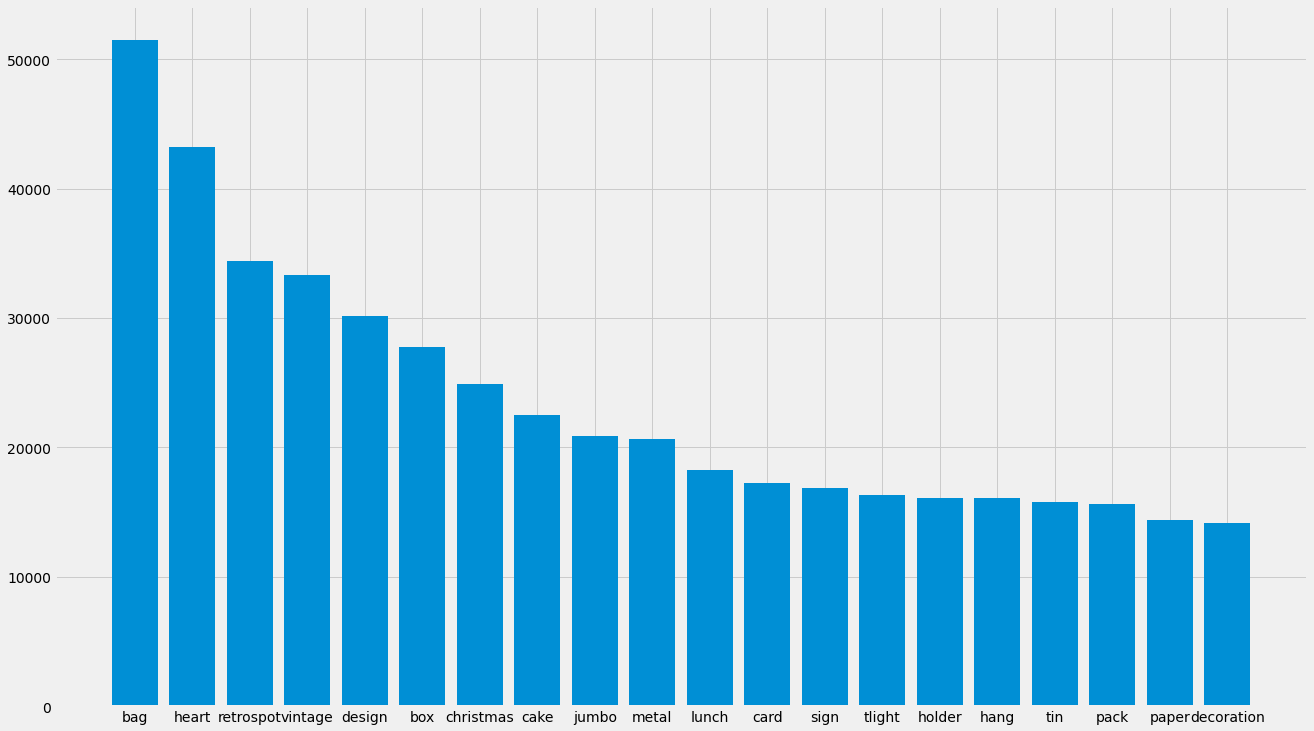

In [13]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())



{'allocate': 2, 'online': 2, 'find': 2, 'waterpump': 2, 'poinsettia': 2, 'minicard': 2, 'necklaceleaf': 2, 'amazon': 2, 'silt': 2, 'squ': 2, 'crome': 2, 'candleincense': 2, 'deck': 2, 'girly': 1, 'loveheart': 1, 'tinsel': 1, 'weekend': 1, 'blackchristmas': 1, 'boombox': 1, 'ipod': 1, 'demi': 1, 'choker': 1, 'opulent': 1, 'snowflakepink': 1, 'banner': 1, 'cutglass': 1, 'ooh': 1, 'bazaar': 1, 'bluenat': 1, 'scallop': 1, 'heavens': 1, 'fragrance': 1, 'purpleturq': 1, 'sell': 1, 'barcode': 1, 'rcvd': 1, 'temp': 1, 'flowerbutterfly': 1, 'mummy': 1, 'tick': 1, 'ret': 1, 'orangefuschia': 1, 'antoienett': 1, 'laser': 1, 'haynes': 1, 'camper': 1, 'whitesilver': 1, 'capiz': 1, 'incorrectly': 1, 'alan': 1, 'hodge': 1, 'mamage': 1, 'section': 1, 'beadshand': 1, 'fba': 1, 'teddycake': 1, 'add': 1, 'retail': 1, 'damage': 1, 'whse': 1, 'website': 1, 'draw': 1, 'trading': 1, 'zero': 1, 'invc': 1, 'incorr': 1, 'michel': 1, 'oops': 1, 'artonly': 1, 'partition': 1, 'panel': 1, 'sale': 1, 'error': 1, 'mir

<BarContainer object of 15 artists>

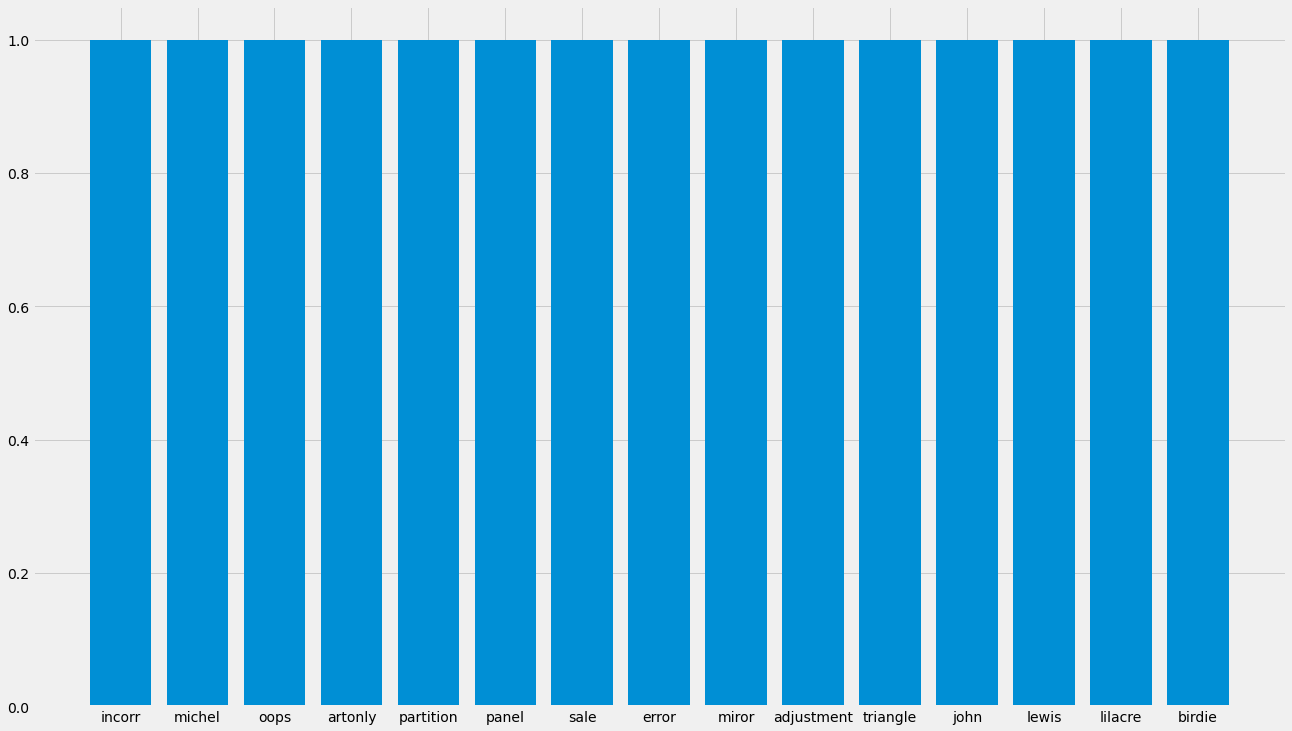

In [14]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-80:])
print(w)
w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-15:])
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())



In [15]:
%%time
# @formatter:on

unique_products = df['StockCodeNum'].unique().tolist()
print(f'Count of unique products: {len(unique_products)}')
for inx, pr in enumerate(unique_products):
    pr_transact = df[df['StockCodeNum'] == pr]
    unique_pr_desc = list(pr_transact['DescriptionEdited'].unique())
    if len(unique_pr_desc) > 1:
        unique_pr_desc = unique_pr_desc[0]
        if inx % 150 == 0:
            display(df[df['StockCodeNum'] == pr].drop_duplicates(['DescriptionEdited', 'StockCodeChar']))
        df.loc[pr_transact.index, 'DescriptionEdited'] = unique_pr_desc
        if inx % 150 == 0:
            display(df[df['StockCodeNum'] == pr].drop_duplicates(['DescriptionEdited', 'StockCodeChar']))
    else:
        unique_products.remove(pr)

print(f'Count of unique products that have changed: {len(unique_products)}')



Count of unique products: 3289


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.3,hang heart tlight holder,hang heart tlight holder
524673,581334,85123a,cream hanging heart t-light holder,4,2011-12-08 12:07:00,2.95,17841,united kingdom,581334,85123,a,11.8,cream hang heart tlight holder,cream hang heart tlight holder


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.3,hang heart tlight holder,hang heart tlight holder


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
1714,536544,47593b,scottie dogs baby bib,2,2010-12-01 14:32:00,0.850,-1,united kingdom,536544,47593,b,1.700,scottie dog baby bib,scottie dog baby bib
25349,538421,47593a,carousel ponies baby bib,2,2010-12-12 12:08:00,1.250,17917,united kingdom,538421,47593,a,2.500,carousel pony baby bib,carousel pony baby bib
129339,547673,47593a,scottie dogs baby bib,13,2011-03-24 13:57:00,0.722,-1,united kingdom,547673,47593,a,9.386,scottie dog baby bib,scottie dog baby bib


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
1714,536544,47593b,scottie dogs baby bib,2,2010-12-01 14:32:00,0.85,-1,united kingdom,536544,47593,b,1.7,scottie dog baby bib,scottie dog baby bib
25349,538421,47593a,carousel ponies baby bib,2,2010-12-12 12:08:00,1.25,17917,united kingdom,538421,47593,a,2.5,scottie dog baby bib,carousel pony baby bib


Count of unique products that have changed: 1756
Wall time: 4.66 s


In [16]:
%%time
# @formatter:on

df = df.drop(df[df['DescriptionEdited'] == ''].index)
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")
print(f"Dataframe length is: {len(df.index)}")
print(f"Portion of dataframe that is removed so far: {(n_rows - len(df.index)) / n_rows * 100:.2f}%")


unique values count: 3179
Dataframe length is: 528901
Portion of dataframe that is removed so far: 0.00%
Wall time: 176 ms


In [17]:
%%time
# @formatter:on

df.to_parquet(path = './data/temp-product-clean-v1.parquet', engine = 'pyarrow')
#df = pd.read_parquet(path = './data/temp-product-clean-v1.parquet', engine = 'pyarrow')



Wall time: 2.06 s


In [17]:
%%time
# @formatter:on

model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')
unique_corpus_sentences = list(df['DescriptionEdited'].unique())
corpus_embeddings = model.encode(unique_corpus_sentences,
                                 batch_size = 64,
                                 show_progress_bar = True,
                                 convert_to_tensor = True)

print("Start clustering")
start_time = time.time()
# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least min_cluster_size elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
detected_clusters = util.community_detection(corpus_embeddings,
                                             min_community_size = 5,
                                             threshold = 0.75, )
print(f"Clustering done after {time.time() - start_time:.2f} sec")
print(f"Number of clusters: {len(detected_clusters)}")

for i, cluster in enumerate(detected_clusters):
    if i % 30 == 0:
        # The first element in each list is the central point in the community.
        print(f"Cluster {i + 1}, #{len(cluster)} Elements")
        for sentence_id in cluster[0:2]:
            print("\t", unique_corpus_sentences[sentence_id])





Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.20 sec
Number of clusters: 79
Cluster 1, #22 Elements
	 silver hang tlight holder
	 multi colour silver tlight holder
Cluster 31, #7 Elements
	 new baroque necklace
	 new baroque bfly necklace
Cluster 61, #5 Elements
	 origami vanilla incense cone
	 origami vanilla incensecandle
Wall time: 37.2 s


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 16/16 [14:11<00:00, 53.25s/it]


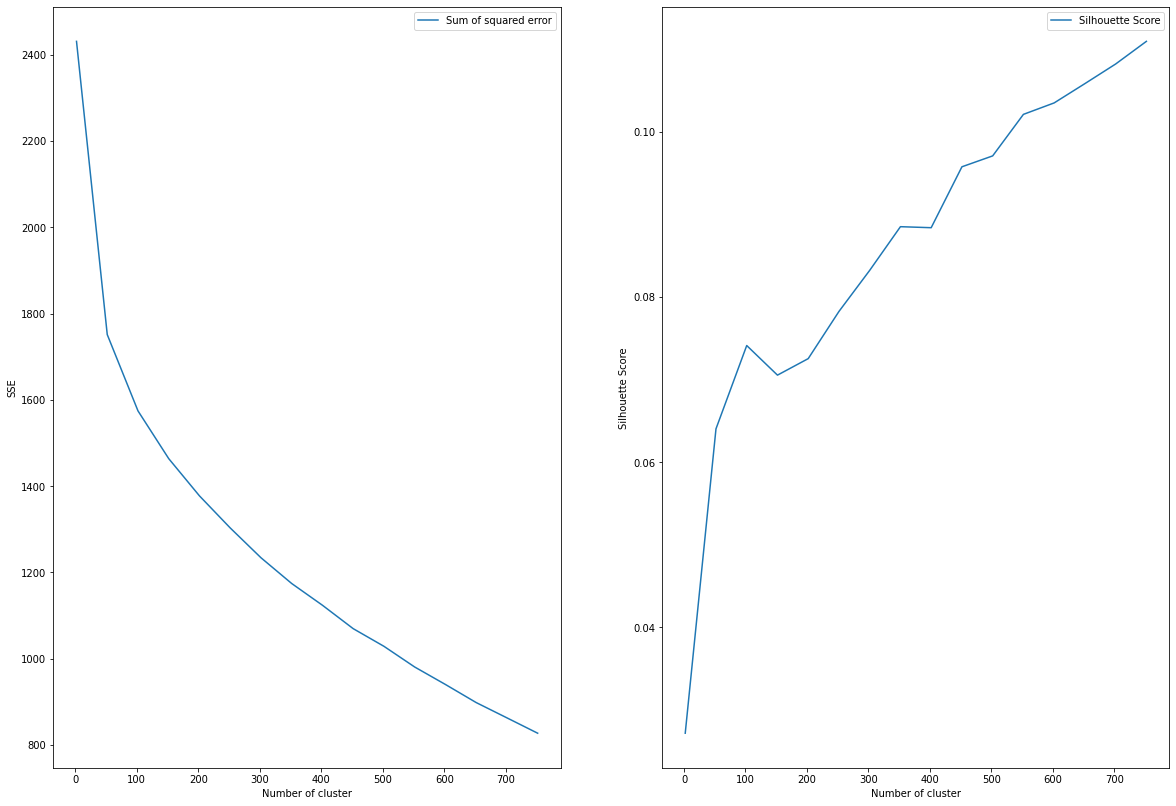

Wall time: 14min 52s


In [7]:
%%time
# @formatter:on

# K-means
if True:

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    model = SentenceTransformer('all-mpnet-base-v2')
    #model = SentenceTransformer('all-MiniLM-L6-v2')
    unique_corpus_sentences = list(df['DescriptionEdited'].unique())
    corpus_embeddings = model.encode(unique_corpus_sentences,
                                     batch_size = 64,
                                     show_progress_bar = True,
                                     convert_to_tensor = False)

    # Perform k-mean clustering
    sse = {}
    kmeans_ref = {}
    silhouette_coefficient = {}
    for num_clusters in tqdm(range(2, 800, 50)):

        clustering_model = KMeans(n_clusters = num_clusters, random_state = 42)
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_

        sse[num_clusters] = clustering_model.inertia_
        clustered_sentences = [[] for i in range(num_clusters)]
        for sentence_id, cluster_id in enumerate(cluster_assignment):
            clustered_sentences[cluster_id].append(unique_corpus_sentences[sentence_id])

        silhouette_coefficient[num_clusters] = silhouette_score(corpus_embeddings, cluster_assignment)

        kmeans_ref[num_clusters] = clustered_sentences

    fig = plt.figure(figsize = (20, 14))
    fig.add_subplot(121)
    plt.plot(list(sse.keys()), list(sse.values()), label = 'Sum of squared error')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.legend()

    fig.add_subplot(122)
    plt.plot(list(silhouette_coefficient.keys()), list(silhouette_coefficient.values()), label = 'Silhouette Score')
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()



In [6]:
%%time
# @formatter:on

if True:
    import pickle

    with open('./data/kmeans-clusters.pkl', 'wb') as handle:
        pickle.dump(kmeans_ref, handle, protocol = pickle.HIGHEST_PROTOCOL)

    # with open('./data/kmeans-clusters.pkl', 'rb') as handle:
    #     unserialized_data = pickle.load(handle)

    selected_n_cluster = 482
    for i, cluster in enumerate(kmeans_ref[selected_n_cluster]):
        df.loc[df[df['DescriptionEdited'].isin(cluster)].index, 'ClusterId'] = i
        if i % 50 == 0:
            print("Cluster ", i + 1)
            print(cluster)
            print("")

    hp.null_val_summary(df = df)



Cluster  1
['glass tassle bag charm', 'fruit salad bag charm', 'summer daisy bag charm', 'summer butterfly bag charm', 'amber glass tassle bag charm', 'bertie glass bead bag charm', 'daisy bag charm', 'metalic leave bag charm', 'metal bag charm', 'copper brass bag charm']

Cluster  51
['ribbon reel make snowman', 'ribbon reel snowy village', 'ribbon reel christmas present', 'ribbon reel sock mitten', 'ribbon reel stripe design', 'ribbon reel polkadot', 'ribbon reel flora fauna', 'ribbon reel lace design', 'vintage tinsel reel', 'ribbon reel heart design', 'embroidered ribbon reel emily', 'embroider ribbon reel ruby', 'embroidered ribbon reel rebecca', 'embroidered ribbon reel daisy', 'embroidered ribbon reel sally', 'embroidered ribbon reel rachel', 'embroidered ribbon reel rosie', 'embroidered ribbon reel susie', 'embroidered ribbon reel sophie', 'embroidered ribbon reel claire']

Cluster  101
['retrospot oven glove', 'tec alpine hand warm', 'retrospot oven glove double', 'tea time ov

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 13.3 s


In [19]:
%%time
# @formatter:on

cluster_centers_embeddings = []
for i, cluster in enumerate(detected_clusters):
    cluster_unique_sentences = []
    cluster_centers_embeddings.append(corpus_embeddings[cluster[0]])
    for sentence_id in cluster:
        cluster_unique_sentences.append(unique_corpus_sentences[sentence_id])
    df.loc[df[df['DescriptionEdited'].isin(cluster_unique_sentences)].index, 'ClusterId'] = i

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,420734
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.548725


Total Quantity of unclustered sales: 4585822, percentage: 81.26
Total Quantity*UnitPrice of unclustered sales: 8296684.39, percentage: 79.42
Wall time: 2.93 s


In [20]:
%%time
# @formatter:on

df['StockCodeNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['StockCodeNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,57.0,79823,155556.869231
217522,556481,23166,medium ceramic top storage jar,3,2011-06-12 13:00:00,1.25,16115,united kingdom,556481,23166,,3.75,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
396486,571844,22197,popcorn holder,24,2011-10-19 12:30:00,0.85,17101,united kingdom,571844,22197,,20.40,popcorn holder,popcorn holder,NaN,56921,51354.020000
14044,537489,84077,world war 2 gliders asstd designs,48,2010-12-07 11:33:00,0.29,17017,united kingdom,537489,84077,,13.92,world war glider asstd design,world war glider asstd design,NaN,55047,13841.850000
506555,580136,85123a,white hanging heart t-light holder,6,2011-12-01 19:42:00,2.95,17841,united kingdom,580136,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
127562,547511,84879,assorted colour bird ornament,8,2011-03-23 13:44:00,1.69,17411,united kingdom,547511,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,NaN,36461,59094.930000
160491,550673,21212,pack of 72 retrospot cake cases,24,2011-04-20 10:28:00,0.55,12971,united kingdom,550673,21212,,13.20,pack retrospot cake case,pack retrospot cake case,NaN,36419,21259.100000
224284,557132,23084,rabbit night light,12,2011-06-17 08:57:00,2.08,13107,united kingdom,557132,23084,,24.96,rabbit night light,rabbit night light,NaN,31722,70012.943333
273486,561507,22492,mini paint set vintage,36,2011-07-27 14:21:00,0.65,12397,belgium,561507,22492,,23.40,mini paint vintage,mini paint vintage,NaN,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
352175,568346,22423,regency cakestand 3 tier,1,2011-09-26 15:28:00,24.96,14096,united kingdom,568346,22423,,24.96,regency cakestand tier,regency cakestand tier,58.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
121591,546986,85099f,jumbo bag strawberry,10,2011-03-18 12:56:00,1.95,14194,united kingdom,546986,85099,f,19.50,jumbo bag strawberry,jumbo bag strawberry,57.0,79823,155556.869231
174387,552262,85123a,white hanging heart t-light holder,6,2011-05-08 11:37:00,2.95,14911,eire,552262,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
199860,554756,47566,party bunting,8,2011-05-26 11:36:00,4.95,16837,united kingdom,554756,47566,,39.60,tea time party bunting,party bunting,NaN,22180,122142.144000
475473,577772,23166,medium ceramic top storage jar,48,2011-11-21 15:53:00,1.04,18139,united kingdom,577772,23166,,49.92,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
495577,579188,23084,rabbit night light,18,2011-11-28 15:34:00,2.08,12748,united kingdom,579188,23084,,37.44,rabbit night light,rabbit night light,NaN,31722,70012.943333
418972,573576,84997a,childrens cutlery polkadot green,1,2011-10-31 14:09:00,8.29,14096,united kingdom,573576,84997,a,8.29,piece polkadot cutlery,children cutlery polkadot,NaN,16749,69181.420000
481095,578225,22086,paper chain kit 50's christmas,6,2011-11-23 11:51:00,2.95,17700,united kingdom,578225,22086,,17.70,paper chain kit christmas,paper chain kit christmas,NaN,19355,64952.290000
24663,538361,22502,picnic basket wicker small,2,2010-12-10 16:36:00,5.95,17757,united kingdom,538361,22502,,11.90,picnic basket wicker,picnic basket wicker,NaN,2048,60861.770000


Wall time: 1.28 s


In [21]:
%%time
# @formatter:on

stacked_centers_embeddings = torch.stack(cluster_centers_embeddings)
# average over cluster
unclustered_df = df[df['ClusterId'].isna()]
unclustered_embeddings = torch.stack(unclustered_df['DescriptionEdited'].apply(lambda x:
                                                                               corpus_embeddings[unique_corpus_sentences.index(x)]).tolist())
df.loc[unclustered_df.index, 'ClusterId'] = torch.argmax(util.cos_sim(unclustered_embeddings, stacked_centers_embeddings), dim = 1).numpy()

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Quantity of unclustered sales: 0, percentage: 0.00
Total Quantity*UnitPrice of unclustered sales: 0.00, percentage: 0.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,61.0,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,57.0,79823,155556.869231
217522,556481,23166,medium ceramic top storage jar,3,2011-06-12 13:00:00,1.25,16115,united kingdom,556481,23166,,3.75,ceramic storage jar,ceramic storage jar,21.0,78033,81700.920000
396486,571844,22197,popcorn holder,24,2011-10-19 12:30:00,0.85,17101,united kingdom,571844,22197,,20.40,popcorn holder,popcorn holder,51.0,56921,51354.020000
14044,537489,84077,world war 2 gliders asstd designs,48,2010-12-07 11:33:00,0.29,17017,united kingdom,537489,84077,,13.92,world war glider asstd design,world war glider asstd design,34.0,55047,13841.850000
506555,580136,85123a,white hanging heart t-light holder,6,2011-12-01 19:42:00,2.95,17841,united kingdom,580136,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
127562,547511,84879,assorted colour bird ornament,8,2011-03-23 13:44:00,1.69,17411,united kingdom,547511,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,24.0,36461,59094.930000
160491,550673,21212,pack of 72 retrospot cake cases,24,2011-04-20 10:28:00,0.55,12971,united kingdom,550673,21212,,13.20,pack retrospot cake case,pack retrospot cake case,25.0,36419,21259.100000
224284,557132,23084,rabbit night light,12,2011-06-17 08:57:00,2.08,13107,united kingdom,557132,23084,,24.96,rabbit night light,rabbit night light,11.0,31722,70012.943333
273486,561507,22492,mini paint set vintage,36,2011-07-27 14:21:00,0.65,12397,belgium,561507,22492,,23.40,mini paint vintage,mini paint vintage,35.0,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
352175,568346,22423,regency cakestand 3 tier,1,2011-09-26 15:28:00,24.96,14096,united kingdom,568346,22423,,24.96,regency cakestand tier,regency cakestand tier,58.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,61.0,80995,168469.600000
121591,546986,85099f,jumbo bag strawberry,10,2011-03-18 12:56:00,1.95,14194,united kingdom,546986,85099,f,19.50,jumbo bag strawberry,jumbo bag strawberry,57.0,79823,155556.869231
174387,552262,85123a,white hanging heart t-light holder,6,2011-05-08 11:37:00,2.95,14911,eire,552262,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
199860,554756,47566,party bunting,8,2011-05-26 11:36:00,4.95,16837,united kingdom,554756,47566,,39.60,tea time party bunting,party bunting,56.0,22180,122142.144000
475473,577772,23166,medium ceramic top storage jar,48,2011-11-21 15:53:00,1.04,18139,united kingdom,577772,23166,,49.92,ceramic storage jar,ceramic storage jar,21.0,78033,81700.920000
495577,579188,23084,rabbit night light,18,2011-11-28 15:34:00,2.08,12748,united kingdom,579188,23084,,37.44,rabbit night light,rabbit night light,11.0,31722,70012.943333
418972,573576,84997a,childrens cutlery polkadot green,1,2011-10-31 14:09:00,8.29,14096,united kingdom,573576,84997,a,8.29,piece polkadot cutlery,children cutlery polkadot,22.0,16749,69181.420000
481095,578225,22086,paper chain kit 50's christmas,6,2011-11-23 11:51:00,2.95,17700,united kingdom,578225,22086,,17.70,paper chain kit christmas,paper chain kit christmas,56.0,19355,64952.290000
24663,538361,22502,picnic basket wicker small,2,2010-12-10 16:36:00,5.95,17757,united kingdom,538361,22502,,11.90,picnic basket wicker,picnic basket wicker,27.0,2048,60861.770000


Wall time: 10.7 s


In [22]:
%%time
# @formatter:on

df['ClusterIdQuantitySum'] = df.groupby('ClusterId')['Quantity'].transform(sum)
df['ClusterIdTotalPriceSum'] = df.groupby('ClusterId')['TotalPrice'].transform(sum)

# top cluster seller
display(df.sort_values(by = ['ClusterIdQuantitySum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))
display(df.sort_values(by = ['ClusterIdTotalPriceSum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
357282,568782,22386,jumbo bag pink polkadot,10,2011-09-29 08:53:00,2.08,13985,united kingdom,568782,22386,,20.80,jumbo bag polkadot,jumbo bag polkadot,54.0,21465,42436.240000,277032,483683.206951
317967,565541,84991,60 teatime fairy cake cases,6,2011-09-05 12:00:00,0.55,14159,united kingdom,565541,84991,,3.30,teatime fairy cake case,teatime fairy cake case,25.0,18214,9183.720000,224593,209384.766667
118820,546789,85099f,jumbo bag strawberry,900,2011-03-17 10:17:00,1.65,15769,united kingdom,546789,85099,f,1485.00,jumbo bag strawberry,jumbo bag strawberry,57.0,79823,155556.869231,202331,342925.289566
64278,541696,79144c,painted lightbulb rainbow design,2,2011-01-20 18:08:00,0.83,-1,united kingdom,541696,79144,c,1.66,paint lightbulb rainbow design,paint lightbulb rainbow design,0.0,334,202.190000,199518,337913.281944
321991,565919,22419,lipstick pen red,5,2011-09-07 16:48:00,0.83,-1,united kingdom,565919,22419,,4.15,lipstick pen,lipstick pen,61.0,3347,1676.880000,190085,279904.385167
79891,543182,22778,glass cloche small,1,2011-02-04 10:40:00,8.29,-1,united kingdom,543182,22778,,8.29,glass cloche,glass cloche,21.0,810,3158.870000,188388,290562.745952
347489,568057,21164,home sweet home metal sign,1,2011-09-23 12:56:00,5.79,-1,united kingdom,568057,21164,,5.79,home sweet home metal sign,home sweet home metal sign,5.0,1768,5161.880000,165830,352269.413797
219803,556730,21564,pink heart shape love bucket,2,2011-06-14 11:40:00,2.95,-1,united kingdom,556730,21564,,5.90,heart shape love bucket,heart shape love bucket,48.0,1042,1831.620000,155491,316782.715672
429744,574559,22076,6 ribbons empire,3,2011-11-04 15:50:00,1.65,14056,united kingdom,574559,22076,,4.95,ribbon empire,ribbon empire,56.0,1260,1669.530000,150658,367898.755222
747,536446,84754,s/15 silver glass baubles in bag,24,2010-12-01 12:15:00,1.25,15983,united kingdom,536446,84754,,30.00,silver glass bauble bag,silver glass bauble bag,4.0,558,725.520000,149155,258935.803381


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
238597,558570,21703,bag 125g swirly marbles,9,2011-06-30 14:38:00,0.42,17673,united kingdom,558570,21703,,3.78,bag swirly marble,bag swirly marble,54.0,9390,3528.890000,277032,483683.206951
369545,569675,84029g,knitted union flag hot water bottle,4,2011-10-05 14:03:00,4.25,15687,united kingdom,569675,84029,g,17.00,knit union flag hot water bottle,knit union flag hot water bottle,1.0,8381,40237.226364,97565,384802.676768
415319,573347,22734,set of 6 ribbons vintage christmas,2,2011-10-30 12:26:00,2.89,13137,united kingdom,573347,22734,,5.78,ribbon vintage christmas,ribbon vintage christmas,56.0,3403,11245.360000,150658,367898.755222
434614,574864,21169,you're confusing me metal sign,4,2011-11-07 12:29:00,1.69,14387,united kingdom,574864,21169,,6.76,confusing metal sign,confusing metal sign,5.0,4424,7320.360000,165830,352269.413797
487779,578707,84859b,blue disco handbag,1,2011-11-25 11:20:00,1.95,17870,united kingdom,578707,84859,b,1.95,disco handbag,disco handbag,57.0,245,520.270000,202331,342925.289566
214641,556187,71459,hanging jam jar t-light holder,24,2011-06-09 11:49:00,0.85,15296,united kingdom,556187,71459,,20.40,hang jam jar tlight holder,hang jam jar tlight holder,0.0,13605,10858.890000,199518,337913.281944
480785,578149,48187,doormat new england,1,2011-11-23 11:11:00,12.46,-1,united kingdom,578149,48187,,12.46,doormat new england,doormat new england,73.0,3830,24292.840000,86282,334957.245038
179157,552672,84988,set of 72 pink heart paper doilies,1,2011-05-10 15:06:00,3.75,-1,united kingdom,552672,84988,,3.75,heart paper doily,heart paper doily,48.0,7312,14762.700000,155491,316782.715672
188647,553541,21068,vintage billboard love/hate mug,1,2011-05-17 15:33:00,2.46,-1,united kingdom,553541,21068,,2.46,vintage billboard lovehate mug,vintage billboard lovehate mug,14.0,1638,1890.330000,147157,297734.795712
110475,545937,23178,jam clock magnet,6,2011-03-08 12:05:00,2.89,12758,portugal,545937,23178,,17.34,jam clock magnet,jam clock magnet,21.0,330,943.920000,188388,290562.745952


Wall time: 998 ms


In [23]:
%%time
# @formatter:on

clusters_center_df = pd.DataFrame()
for cluster_id, df_cluster in df.groupby(['ClusterId']):
    clusters_center_df = clusters_center_df.append({'Id': int(cluster_id),
                                                    'Center': corpus_embeddings[detected_clusters[int(cluster_id)][0]].numpy(),
                                                    'CommonWords': ' '.join(
                                                        list(dict(Counter([i for j in df_cluster['DescriptionEdited'].str.split().tolist()
                                                                           for i in j]).most_common(5)).keys()))},
                                                   ignore_index = True)
    if cluster_id % 50 == 0:
        display(df_cluster.drop_duplicates(subset = ['DescriptionEdited']))

clusters_center_df.to_parquet(path = './data/product-clustered-center-v1.parquet', engine = 'pyarrow')
# df1 = pd.read_parquet(path = './data/product-clustered-center-v1.parquet', engine = 'pyarrow')
# df1['Center'] = df1['Center'].apply(lambda x: torch.from_numpy(x))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778,199518,337913.281944
155,536384,84755,colour glass t-light holder hanging,48,2010-12-01 09:53:00,0.65,18074,united kingdom,536384,84755,,31.20,colour glass tlight holder hang,colour glass tlight holder hang,0.0,16449,10518.250000,199518,337913.281944
211,536390,84970s,hanging heart zinc t-light holder,144,2010-12-01 10:19:00,0.64,17511,united kingdom,536390,84970,s,92.16,hang heart zinc tlight holder,hang heart zinc tlight holder,0.0,15409,15000.650000,199518,337913.281944
325,536401,20820,silver looking mirror,3,2010-12-01 11:21:00,4.95,15862,united kingdom,536401,20820,,14.85,silver look mirror,silver look mirror,0.0,5,24.750000,199518,337913.281944
438,536408,22465,hanging metal star lantern,12,2010-12-01 11:41:00,1.65,14307,united kingdom,536408,22465,,19.80,hang metal star lantern,hang metal star lantern,0.0,2060,3153.090000,199518,337913.281944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290584,563018,23326,hanging mini coloured bottles,48,2011-08-11 12:53:00,0.63,13427,united kingdom,563018,23326,,30.24,hang mini coloured bottle,hang mini coloured bottle,0.0,3443,2237.710000,199518,337913.281944
317659,565472,23406,home sweet home key holder,1,2011-09-05 10:15:00,6.25,16255,united kingdom,565472,23406,,6.25,home sweet home key holder,home sweet home key holder,0.0,472,2534.847500,199518,337913.281944
363923,569327,23483,hanging butterfly t-light holder,12,2011-10-03 12:47:00,1.25,15091,united kingdom,569327,23483,,15.00,hang butterfly tlight holder,hang butterfly tlight holder,0.0,1340,1651.360000,199518,337913.281944
387363,571203,23490,t-light holder hanging love bird,6,2011-10-14 12:33:00,3.75,17677,united kingdom,571203,23490,,22.50,tlight holder hang love bird,tlight holder hang love bird,0.0,548,2055.270000,199518,337913.281944


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
33,536370,21724,panda and bunnies sticker sheet,12,2010-12-01 08:45:00,0.850000,12583,france,536370,21724,,10.200000,panda bunny sticker sheet,panda bunny sticker sheet,50.0,408,355.830000,53718,36567.825455
470,536408,16237,sleeping cat erasers,30,2010-12-01 11:41:00,0.210000,14307,united kingdom,536408,16237,,6.300000,sleep cat eraser,sleep cat eraser,50.0,4994,1048.560000,53718,36567.825455
488,536409,21676,flowers stickers,6,2010-12-01 11:45:00,0.850000,17908,united kingdom,536409,21676,,5.100000,flower sticker,flower sticker,50.0,257,245.360000,53718,36567.825455
491,536409,21678,paisley pattern stickers,6,2010-12-01 11:45:00,0.850000,17908,united kingdom,536409,21678,,5.100000,paisley pattern sticker,paisley pattern sticker,50.0,125,111.860000,53718,36567.825455
806,536464,10125,mini funky design tapes,2,2010-12-01 12:23:00,0.850000,17968,united kingdom,536464,10125,,1.700000,mini funky design tape,mini funky design tape,50.0,1296,994.840000,53718,36567.825455
820,536464,22731,3d christmas stamps stickers,2,2010-12-01 12:23:00,1.250000,17968,united kingdom,536464,22731,,2.500000,christmas stamp sticker,christmas stamp sticker,50.0,1172,1536.240000,53718,36567.825455
1402,536540,85136a,yellow shark helicopter,2,2010-12-01 14:05:00,7.950000,14911,eire,536540,85136,a,15.900000,shark helicopter,shark helicopter,50.0,126,1017.440000,53718,36567.825455
1807,536544,84598,boys alphabet iron on patches,2,2010-12-01 14:32:00,0.430000,-1,united kingdom,536544,84598,,0.860000,boy alphabet iron patch,boy alphabet iron patch,50.0,1975,546.040000,53718,36567.825455
1830,536544,16236,kitty pencil erasers,1,2010-12-01 14:32:00,0.430000,-1,united kingdom,536544,16236,,0.430000,kitty pencil eraser,kitty pencil eraser,50.0,1438,320.090000,53718,36567.825455
1925,536544,21407,brown check cat doorstop,2,2010-12-01 14:32:00,8.470000,-1,united kingdom,536544,21407,,16.940000,check cat doorstop,check cat doorstop,50.0,290,1421.110000,53718,36567.825455


Wall time: 1.5 s


In [24]:
%%time
# @formatter:on

df = df.drop(columns = ['DescriptionEditedTemp'])
df.to_parquet(path = './data/transaction-clustered-v1.parquet', engine = 'pyarrow')



Wall time: 774 ms


Wall time: 27.8 s


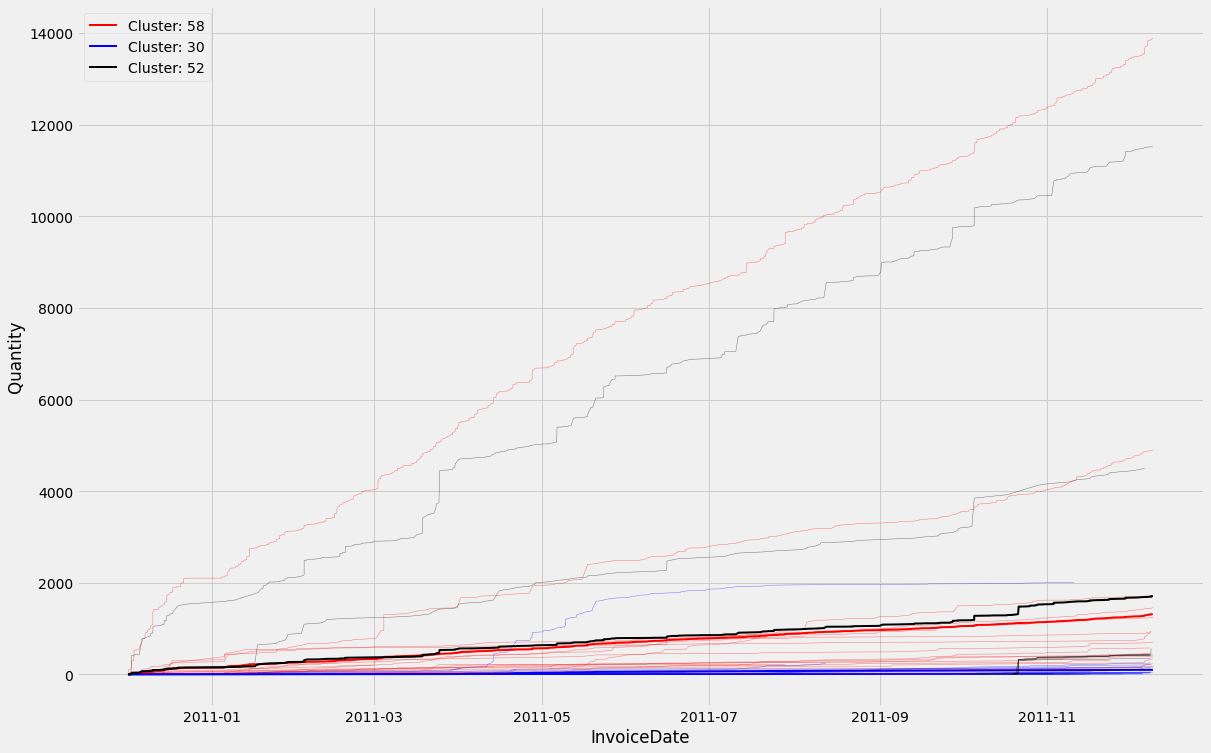

In [25]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))
unique_cluster_ids = df['ClusterId'].unique()
random_cluster_ids = np.random.choice(unique_cluster_ids.shape[0], 3, replace = False)
colors = ['red', 'blue', 'black']

# add max to product dfplot
for inx, c_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == unique_cluster_ids[c_id]]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(unique_cluster_ids[c_id])}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 27.2 s


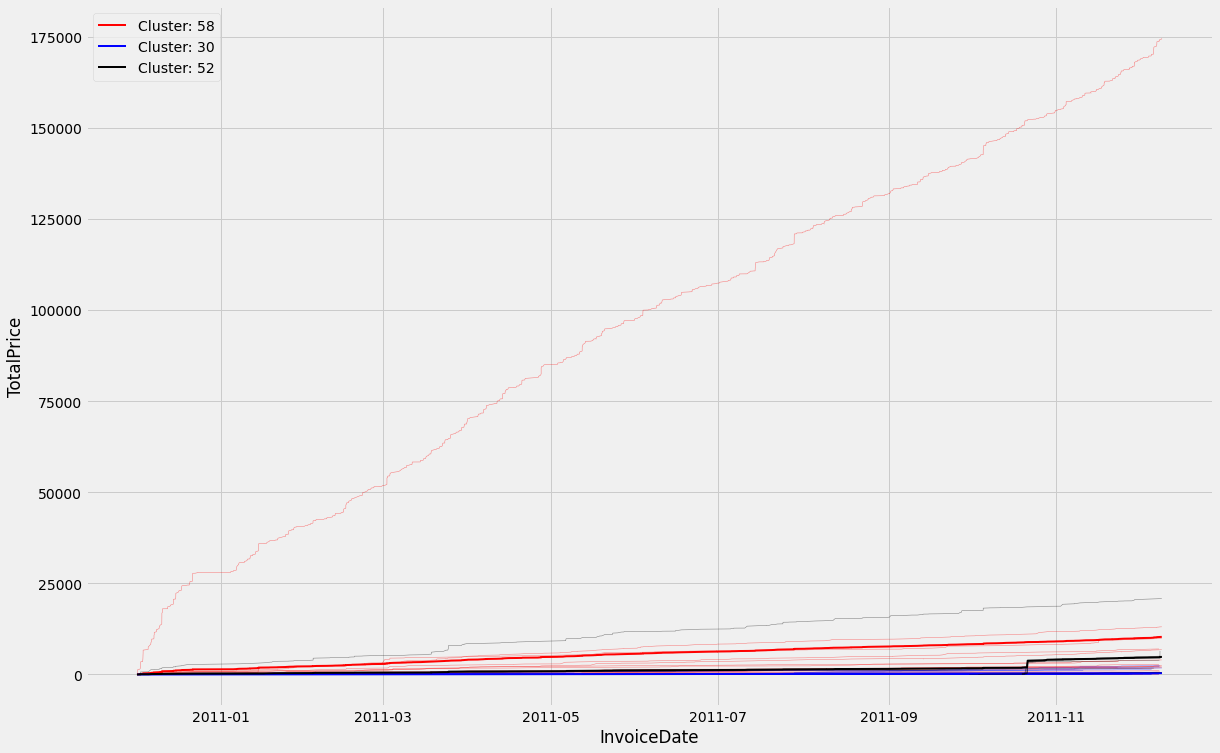

In [26]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))

for inx, c_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == unique_cluster_ids[c_id]]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(unique_cluster_ids[c_id])}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 3min 30s


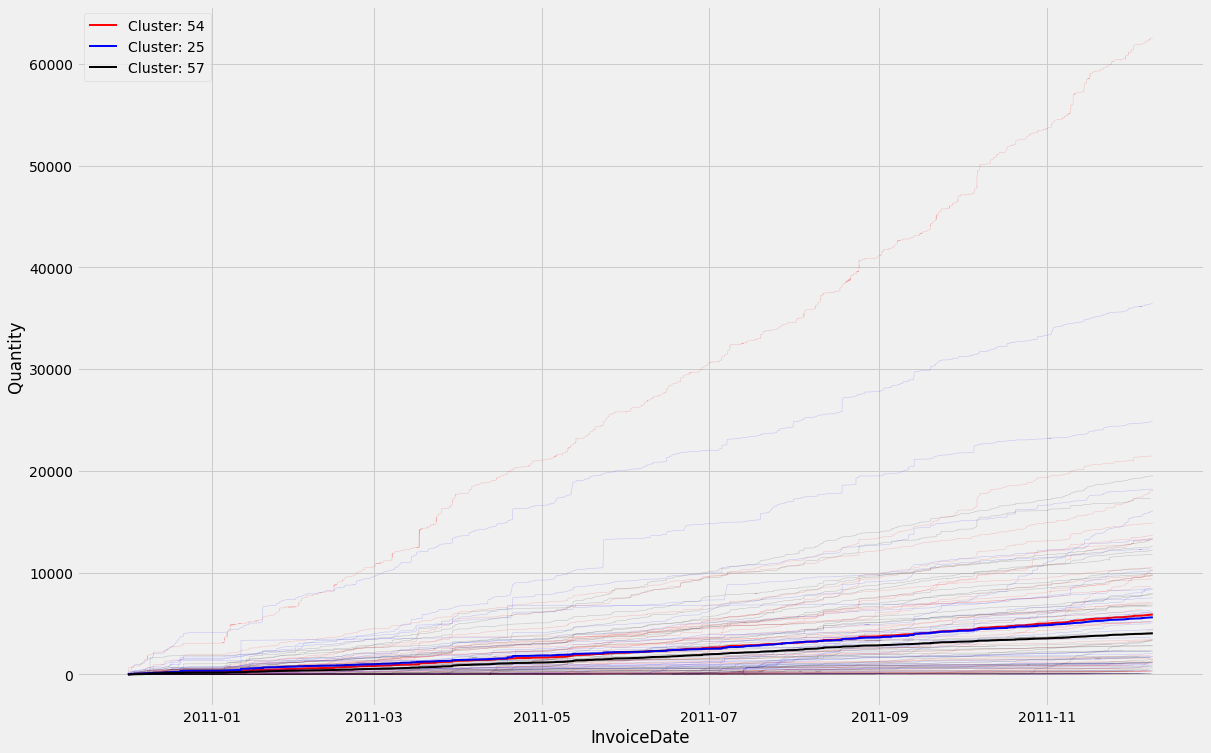

In [27]:
%%time
# @formatter:on

top_quantity_sum_cluster_ids = df.sort_values(by = ['ClusterIdQuantitySum'],
                                              ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_quantity_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 3min 57s


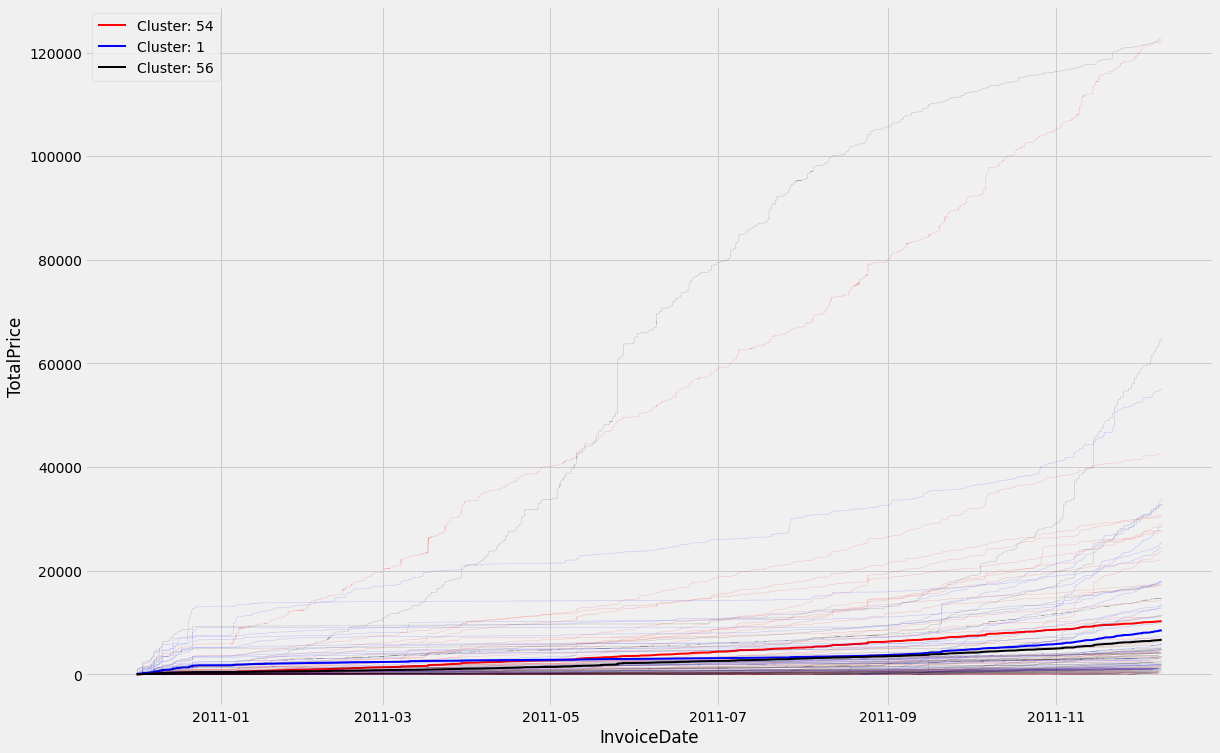

In [28]:
%%time
# @formatter:on

top_total_price_sum_cluster_ids = df.sort_values(by = ['ClusterIdTotalPriceSum'],
                                                 ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_total_price_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])

